In [1]:
import pandas as pd
from utils import drop_skewed_features, drop_correlated_features
from aencoder import Autoencoder
from aencoder import train_autoencoder, get_latent_representation
import torch
import os

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [96]:
def create_grouped_symptom_df(sympdf_path, symp_groups_path, clusters_path, exclude_features=None):
    """
    Creates a DataFrame with symptoms grouped according to specified groups and excludes specified features from grouping,
    adding them as separate columns instead.

    Parameters:
    - sympdf_path (str): Path to CSV file with symptom data.
    - symp_groups_path (str): Path to CSV file with symptom group definitions.
    - clusters_path (str): Path to CSV file with clusters.
    - exclude_features (list of str, optional): Features to exclude from grouping and include as separate columns.

    Returns:
    - DataFrame: Symptoms grouped by specified groups and excluded features as separate columns, indexed by clusters.
    """
    # Load data
    sympdf = pd.read_csv(sympdf_path, index_col=0)
    symp_groups = pd.read_csv(symp_groups_path)
    clusters = pd.read_csv(clusters_path, index_col=0)
    sympdf['cluster'] = clusters['cluster']

    # Initialize the DataFrame with clusters as the index
    grouped_data = pd.DataFrame(index=clusters['cluster'].unique())

    # Exclude specified features from the groups, if any
    if exclude_features is not None:
        for feature in exclude_features:
            if feature in sympdf.columns:
                grouped_data[feature] = sympdf.groupby('cluster')[feature].mean()

    # Group symptoms according to symp_groups, excluding specified features
    for group_name in symp_groups['group'].unique():
        group_symptoms = symp_groups.loc[symp_groups['group'] == group_name, 'symptom']
        relevant_symptoms = sympdf.columns.intersection(group_symptoms).difference(exclude_features or [])
        if not relevant_symptoms.empty:
            # Compute the mean for each cluster for the current group
            grouped_avg = sympdf.groupby('cluster')[relevant_symptoms].mean().mean(axis=1)
            grouped_data[group_name] = grouped_avg

    # Ensure the index is sorted to maintain the cluster order
    grouped_data.sort_index(inplace=True)
    
    return grouped_data

sympdf_path = "/Users/leo/Programming/PLR/Leo/data/cleaned_data_SYMPTOMS_9_13_23.csv"
symp_groups_path = "/Users/leo/Programming/PLR/clusterings/tessa/symptom_groups.csv"
clusters_path = "/Users/leo/Programming/PLR/clusterings/leo/final_aencoder_hdbscan_6.csv"

grouped_df = create_grouped_symptom_df(sympdf_path, symp_groups_path, clusters_path)

exclude_features = ["Physical_PEM_Severity", "Cognitive_PEM_Severity"]

grouped_df_pem = create_grouped_symptom_df(sympdf_path, symp_groups_path, clusters_path, exclude_features)

In [68]:
df = pd.read_csv('/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl2/cl2_full_dataset.csv')

opt_params = {'silhouette_score': 0.5902, 'num_clusters': 9, 'skew_threshold': 0.8, 'corr_threshold': 0.5, 'hidden_size': 64, 'latent_dim': 2, 'learning_rate': 0.01, 'epochs': 500, 'hdbscan_params': {'min_cluster_size': 5, 'min_samples': 25}, 'dataset': 5}

In [71]:
def calculate_cluster_sizes(df):
    """
    Calculate the sizes of each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'cluster' column.

    Returns:
    Series: A pandas Series with cluster labels as index and their respective sizes as values.
    """
    cluster_sizes = df.groupby('cluster').size()
    return cluster_sizes

In [6]:
calculate_cluster_sizes(df)

cluster
-1     222
 0    1125
 1    2126
 2     321
 3     498
 4     850
 5     889
dtype: int64

In [7]:
def average_symptom_count_by_cluster(df):
    """
    Calculate the average symptom count for each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with columns for symptoms starting with "Symptom_" and a 'cluster' column.

    Returns:
    DataFrame: A pandas DataFrame with the average symptom count for each cluster.
    """
    # Filter columns that start with 'Symptom_'
    symptom_columns = [col for col in df.columns if col.startswith('Symptom_')]

    # Sum the symptom columns for each row
    df['total_symptoms'] = df[symptom_columns].sum(axis=1)

    # Calculate the average symptom count for each cluster
    average_symptoms = round(df.groupby('cluster')['total_symptoms'].mean(),0)

    return average_symptoms

# Example usage
# Assuming you have your DataFrame loaded as 'df'
average_symptoms = average_symptom_count_by_cluster(df)
print(average_symptoms)


cluster
-1    16.0
 0    44.0
 1    60.0
 2    35.0
 3    46.0
 4    28.0
 5    37.0
Name: total_symptoms, dtype: float64


In [9]:
df["Demographics_Gender_Cleaned"].value_counts()

Demographics_Gender_Cleaned
Woman                                           4703
Man                                             1205
Non-binary/Genderqueer/Gender non-conforming     100
Name: count, dtype: int64

In [10]:
df["Demographics_Age_Cleaned"].value_counts()

Demographics_Age_Cleaned
40-49    1725
50-59    1460
30-39    1352
60-69     736
18-29     526
70-79     213
80+        19
Name: count, dtype: int64

In [11]:
def average_women_to_other_ratio_by_cluster(df):
    """
    Calculate the average ratio of 'Women' to 'Other' for each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'Demographics_Gender_Cleaned' and a 'cluster' column.

    Returns:
    Series: A pandas Series with cluster labels as index and the average ratio of 'Women' to 'Other' as values.
    """
    # Create a new column for 'Woman' (1) and 'Other' (0)
    df['woman_or_other'] = df['Demographics_Gender_Cleaned'].apply(lambda x: 1 if x == 'Woman' else 0)

    # Calculate the average ratio for each cluster
    average_ratios = round(df.groupby('cluster')['woman_or_other'].mean(),3)

    return average_ratios

average_women_to_other_ratio_by_cluster(df)

cluster
-1    0.667
 0    0.795
 1    0.830
 2    0.791
 3    0.791
 4    0.714
 5    0.721
Name: woman_or_other, dtype: float64

In [12]:
def convert_age(age_string):
    conversion_dict = {
        '30-39': 35,
        '40-49': 45,
        '50-59': 55,
        '18-29': 24,
        '60-69': 65,
        '70-79': 75,
        '80+': 85
    }
    return conversion_dict[age_string]

def average_age_by_cluster(df):
    """
    Calculate the average age for each cluster in the DataFrame, rounded to one decimal place.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'Demographics_Age_Cleaned' and a 'cluster' column.

    Returns:
    DataFrame: A pandas DataFrame with cluster labels as index and the average age as values, rounded to one decimal place.
    """
    # Convert age ranges to average ages
    df['average_age'] = df['Demographics_Age_Cleaned'].apply(convert_age)

    # Calculate the average age for each cluster
    average_ages = df.groupby('cluster')['average_age'].mean().round(1)

    return average_ages

In [13]:
average_age_by_cluster(df)

cluster
-1    47.6
 0    47.3
 1    46.7
 2    45.9
 3    46.3
 4    47.7
 5    47.1
Name: average_age, dtype: float64

In [14]:
df["Cognitive_PEM_Severity"].value_counts()

Cognitive_PEM_Severity
8.0     772
7.0     724
0.0     610
5.0     603
6.0     565
10.0    520
9.0     479
4.0     346
3.0     298
2.0     216
1.0     196
Name: count, dtype: int64

In [15]:
def average_normalized_pem_severity_by_cluster(df):
    """
    Calculate the average normalized PEM severity for each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'Physical_PEM_Severity' column and a 'cluster' column.

    Returns:
    Series: A pandas Series with cluster labels as index and the average normalized PEM severity as values.
    """
    # Normalize the 'Physical_PEM_Severity' column
    df['normalized_pem_severity'] = df['Physical_PEM_Severity'] / 10

    # Calculate the average normalized PEM severity for each cluster
    average_severity = round(df.groupby('cluster')['normalized_pem_severity'].mean(),3)

    return average_severity

average_normalized_pem_severity_by_cluster(df)

cluster
-1    0.619
 0    0.773
 1    0.811
 2    0.747
 3    0.773
 4    0.719
 5    0.735
Name: normalized_pem_severity, dtype: float64

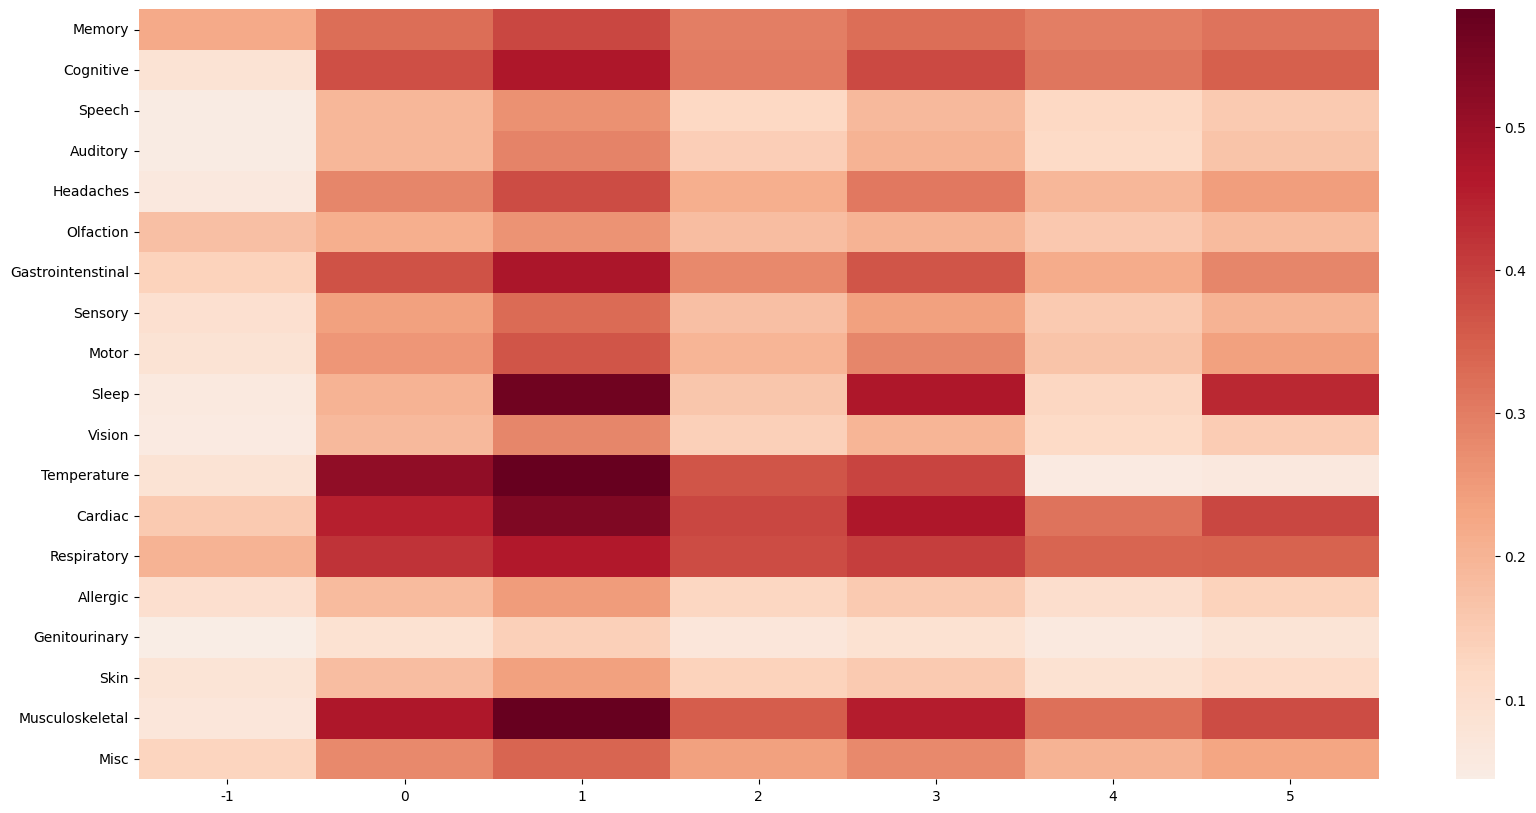

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grouped_symp_freq(grouped_data, mode="mean", saveloc=None):
    """
    Plot grouped symptom frequencies by cluster.

    Parameters:
    grouped_data (DataFrame): DataFrame with symptoms already grouped by cluster.
    mode (str): Aggregation mode, 'mean' by default. [Note: This parameter is kept for potential future use]
    saveloc (str, optional): Location to save the plot. Default is None.

    Returns:
    None: Directly plots the heatmap of average scores by symptom group.
    """
    # Check if 'mode' is implemented, for now, it's not used but can be expanded for different aggregations
    if mode != "mean":
        raise ValueError("Currently, only 'mean' mode is supported.")

    # Use the provided grouped_data for plotting
    plt.figure(figsize=(20, 10))
    sns.heatmap(grouped_data.transpose(), cmap='RdBu_r', center=0, annot=False)

    if saveloc is not None:
        plt.savefig(saveloc)

    plt.show()

    
avg_df_grouped = plot_grouped_symp_freq(grouped_df)

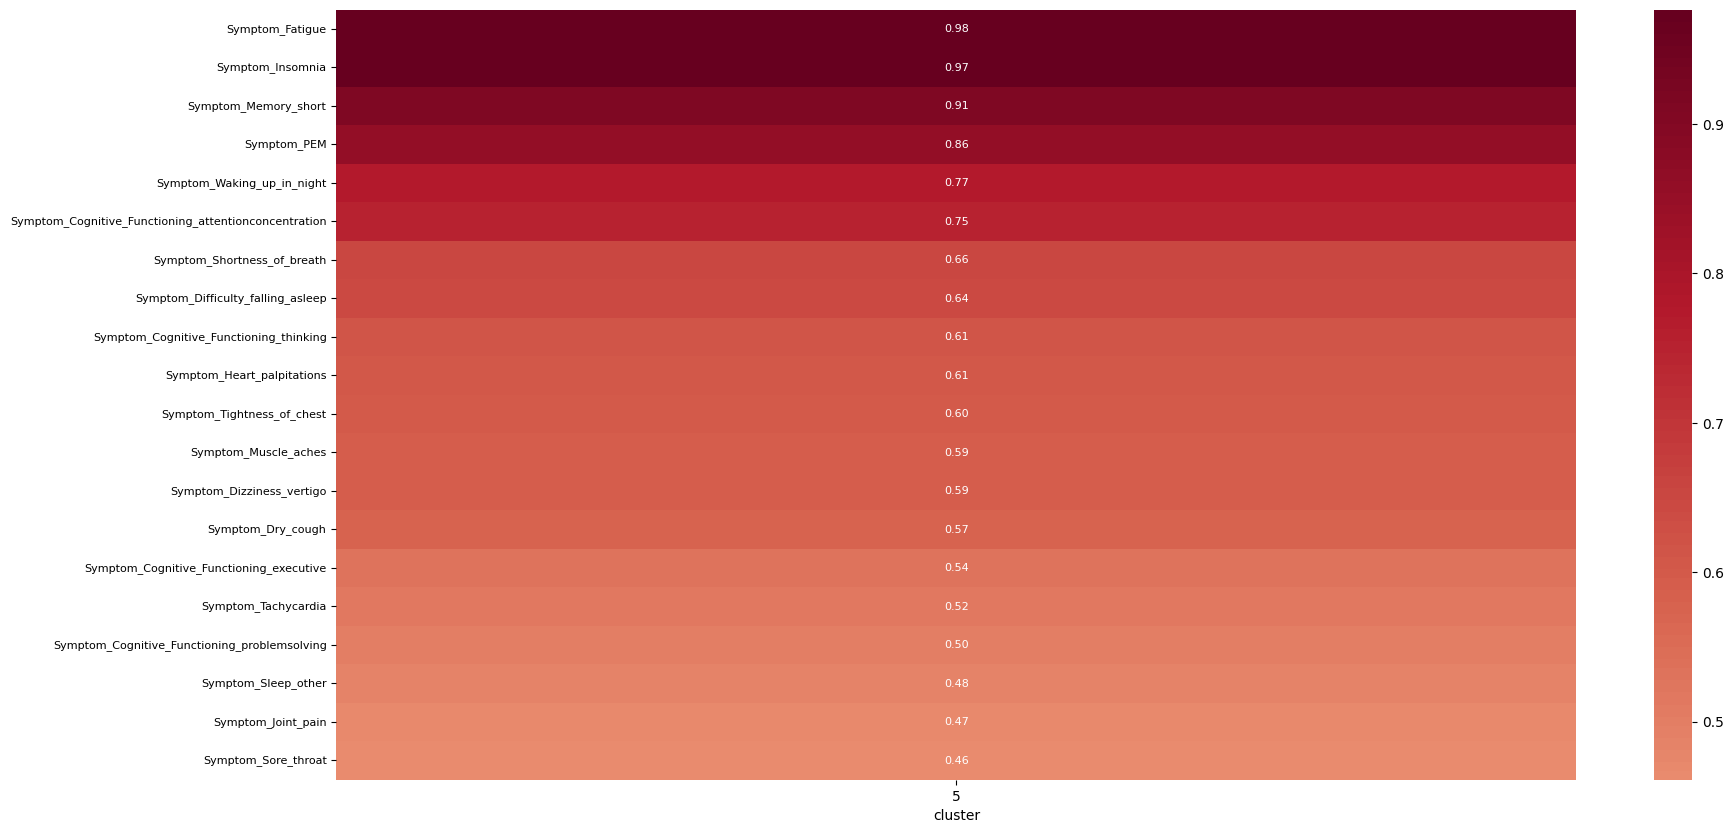

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_symp_avg_per_cluster(clusters, sympdf=None, include_misc=True, saveloc=None, selected_cluster=None, top_n_features=None):
    """
    Plot average symptom values by cluster, with options to filter by specific cluster
    and to limit the display to top n highest features, including value annotations.

    Parameters:
    clusters (str or DataFrame): Path to CSV file with clusters or DataFrame with clusters.
    sympdf (DataFrame, optional): DataFrame with symptoms. Default is None.
    include_misc (bool): Whether to include 'Misc' symptoms. Default is True.
    saveloc (str, optional): Location to save the plot. Default is None.
    selected_cluster (int or str, optional): Specific cluster to display. Default is None.
    top_n_features (int, optional): Number of top features to display. Default is None.

    Returns:
    DataFrame: Average scores by symptom.
    """
    # Read clusters from CSV if it's a string
    if isinstance(clusters, str):
        clusters = pd.read_csv(clusters, index_col=0)

    if sympdf is None:
        # Placeholder for actual symptoms data path
        df = pd.read_csv("/Users/leo/Programming/PLR/Leo/data/cleaned_data_SYMPTOMS_9_13_23.csv", index_col=0)
        sympdf = df.loc[:, df.columns.str.startswith('Symptom_')]

    if not include_misc:
        sympdf = sympdf.drop(columns=[col for col in sympdf.columns if 'Misc' in col], errors='ignore')

    sympdf['cluster'] = clusters['cluster']

    if selected_cluster is not None:
        sympdf = sympdf[sympdf['cluster'] == selected_cluster]

    # Compute the mean for each symptom per cluster
    avg_scores_by_symptom = sympdf.groupby('cluster').mean()

    if top_n_features is not None:
        transposed_avg_scores = avg_scores_by_symptom.transpose()
        
        if selected_cluster is None:
            mean_scores = transposed_avg_scores.mean(axis=1)
        else:
            mean_scores = transposed_avg_scores[selected_cluster]
        
        top_features = mean_scores.nlargest(top_n_features).index
        transposed_avg_scores = transposed_avg_scores.loc[top_features]
    else:
        transposed_avg_scores = avg_scores_by_symptom.transpose()

    # Dynamically adjust figure size based on the number of features to display
    fig_height = max(10, len(transposed_avg_scores) * 0.5)  # Adjust the multiplier as needed to increase row height
    plt.figure(figsize=(20, fig_height))

    ax = sns.heatmap(transposed_avg_scores, cmap='RdBu_r', center=0, annot=True, fmt=".2f", annot_kws={"size": 8})
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size=8)

    if saveloc is not None:
        plt.savefig(saveloc)

    plt.show()

    return avg_scores_by_symptom

# Note: Replace "path_to_symptoms_data.csv" and the clusters path with actual paths.


# Example usage
plot_avg_per_cluster= plot_symp_avg_per_cluster(
    clusters="/Users/leo/Programming/PLR/clusterings/leo/final_aencoder_hdbscan_6.csv",
    include_misc=False,
    selected_cluster=5,  # Updated to use a numerical cluster label
    top_n_features=20,
    saveloc=None  # Optionally specify a save location for the plot
)


In [19]:
import pandas as pd

# Path to the CSV file containing cluster assignments
clusters_csv_path = "/Users/leo/Programming/PLR/clusterings/leo/final_aencoder_hdbscan_6.csv"

# Read the cluster assignments from the CSV
clusters_df = pd.read_csv(clusters_csv_path)

# Assuming the cluster assignments are in the last column, get the unique cluster names/labels
unique_clusters = clusters_df.iloc[:, -1].unique()

print("Unique cluster names/labels found in the dataset:", unique_clusters)


Unique cluster names/labels found in the dataset: [ 1  5  0  2  3 -1  4]


In [83]:
def compute_symptom_group_difference(df):
    """
    Compute the difference in average symptom group scores for each cluster from the overall average.

    Parameters:
    df (DataFrame): DataFrame containing symptom group scores with clusters as rows and symptom groups as columns.

    Returns:
    DataFrame: A DataFrame showing the difference in average symptom group scores for each cluster.
    """

    # Calculate the overall average for each symptom group
    overall_avg = df.mean()

    # Calculate the difference for each cluster
    difference_df = df.subtract(overall_avg, axis='columns')

    return difference_df

# Assuming your DataFrame is named df
# df = your_dataframe_with_clusters_and_symptoms
enriched_df = compute_symptom_group_difference(grouped_df)

In [84]:
enriched_df

,Memory,Cognitive,Speech,Auditory,Headaches,Olfaction,Gastrointenstinal,Sensory,Motor,Sleep,Vision,Temperature,Cardiac,Respiratory,Allergic,Genitourinary,Skin,Musculoskeletal,Misc
-1,-0.088953,-0.242303,-0.108142,-0.116082,-0.177627,-0.021108,-0.168638,-0.110291,-0.143528,-0.230829,-0.109369,-0.211547,-0.234836,-0.161525,-0.052995,-0.037314,-0.062577,-0.304602,-0.113839
0,0.016181,0.049315,0.035324,0.026954,0.043862,0.016772,0.066308,0.033534,0.027583,-0.086010,0.029046,0.222023,0.064645,0.054543,0.036772,0.008319,0.038372,0.094674,0.034807
1,0.076256,0.147681,0.111309,0.119746,0.137567,0.066151,0.172373,0.124946,0.138496,0.274676,0.123182,0.288148,0.156750,0.103519,0.097530,0.055653,0.099304,0.205002,0.094507
2,-0.014001,-0.023351,-0.034291,-0.021099,-0.027812,-0.016877,-0.022898,-0.027315,-0.030600,-0.127083,-0.021879,0.072289,0.001697,0.014882,-0.024443,-0.011365,-0.005892,-0.022745,-0.004665
3,0.016735,0.060454,0.031437,0.038687,0.067087,0.008538,0.060851,0.034070,0.055769,0.180693,0.036747,0.099569,0.083193,0.037318,0.004303,0.009104,0.011707,0.080777,0.037811
4,-0.011280,-0.012168,-0.033036,-0.047178,-0.045809,-0.040607,-0.087063,-0.051160,-0.061861,-0.162329,-0.046350,-0.241548,-0.071088,-0.027732,-0.046432,-0.021341,-0.051994,-0.054666,-0.038301
5,0.005061,0.020372,-0.002600,-0.001028,0.002731,-0.012869,-0.020933,-0.003785,0.014140,0.150882,-0.011378,-0.228934,-0.000361,-0.021005,-0.014734,-0.003056,-0.028920,0.001561,-0.010319


In [23]:
avg_df

,Symptom_Memory_short,Symptom_Memory_long,Symptom_Memory_no_new_memories,Symptom_Memory_forget_tasks,Symptom_Memory_other,Symptom_Cognitive_Functioning_thinking,Symptom_Cognitive_Functioning_executive,Symptom_Cognitive_Functioning_problemsolving,Symptom_Cognitive_Functioning_slowedthoughts,Symptom_Cognitive_Functioning_fastthoughts,Symptom_Cognitive_Functioning_agnosia,Symptom_Cognitive_Functioning_attentionconcentration,Symptom_Cognitive_Functioning_other,Symptom_Speech_difficulty_finding_words,Symptom_Speech_difficulty_communicating_verbally,Symptom_Speech_difficulty_reading_processing_text,Symptom_Speech_difficulty_understanding_others_speech,Symptom_Speech_difficulty_speaking_complete_sentences,Symptom_Speech_speaking_unrecognizable_words,Symptom_Speech_difficulty_communicating_writing,Symptom_Speech_changes_to_secondary_languages,Symptom_Speech_other,Symptom_Headaches_behind_eyes,Symptom_Headaches_stiff_neck,Symptom_Headaches_brain_pressure,Symptom_Headaches_diffuse,Symptom_Headaches_temples,Symptom_Headaches_base_of_skull,Symptom_Headaches_after_mental_exertion,Symptom_Headaches_migraines,Symptom_Headaches_other,Symptom_Headaches_brain_warmth,Symptom_Loss_of_smell,Symptom_Loss_of_taste,Symptom_Altered_taste,Symptom_Phantom_smell,Symptom_Altered_smell,Symptom_Phantom_taste,Symptom_Heightened_smell,Symptom_Heightened_taste,Symptom_Vibrating_sensations,Symptom_Tremors,Symptom_Insomnia,Symptom_Night_sweats,Symptom_Awakened_cannot_breathe,Symptom_Vivid_dreams,Symptom_Nightmares,Symptom_Restless_leg,Symptom_Lucid_dreams,Symptom_Sleep_apnea,Symptom_Sleep_other,Symptom_Difficulty_falling_asleep,Symptom_Waking_up_early,Symptom_Waking_up_in_night,Symptom_Hallucinations_visual,Symptom_Hallucinations_auditory,Symptom_Hallucinations_tactile,Symptom_Hallucinations_other,Symptom_Sensations_skin_burning_no_rash,Symptom_Sensations_numbness_loss_sensation,Symptom_Sensations_numbness_one_sided_weakness,Symptom_Sensations_coldness,Symptom_Sensations_tingling_prickling,Symptom_Sensations_electrical_zaps,Symptom_Sensations_weakness,Symptom_Sensations_facial_pressure_left,Symptom_Sensations_facial_pressure_right,Symptom_Sensations_facial_pressure_other,Symptom_Sensations_facial_paralysis,Symptom_Temp_lability,Symptom_Heat_intolerance,Symptom_Merged_temperature_other_temp_issues,Symptom_Elevated_temp,Symptom_Fever,Symptom_Low_temp,Symptom_Chills_flushing_sweats,Symptom_Tachycardia,Symptom_Bradycardia,Symptom_Heart_palpitations,Symptom_Bulging_veins,Symptom_Fainting,Symptom_Dizziness_vertigo,Symptom_Neuralgia,Symptom_Gasping_air_normal_oxygen,Symptom_New_anaphylaxis,Symptom_Acute_confusion,Symptom_Slurring_words,Symptom_Constipation,Symptom_Diarrhea,Symptom_Vomiting,Symptom_Nausea,Symptom_Loss_of_appetite,Symptom_Acid_reflux,Symptom_Dry_cough,Symptom_Cough_with_mucus,Symptom_Coughing_up_blood,Symptom_Shortness_of_breath,Symptom_Tightness_of_chest,Symptom_Sneezing,Symptom_Runny_nose,Symptom_Pain_burning_chest,Symptom_Rattling_breath,Symptom_Sore_throat,Symptom_Respiratory_other,Symptom_Hearing_loss,Symptom_Tinnitus,Symptom_Eye_vision_symptoms,Symptom_Reproductive_all_menstrual_issues,Symptom_Bladder_control,Symptom_Peeling_skin,Symptom_Petechiae,Symptom_Covid_toes,Symptom_Dermatographia,Symptom_Skin_rashes,Symptom_Skin_Allergy_other,Symptom_Muscle_spasms,Symptom_Muscle_aches,Symptom_Joint_pain,Symptom_Bone_ache_burning,Symptom_Inability_to_yawn,Symptom_Difficulty_swallowing,Symptom_Changes_in_voice,Symptom_Extreme_thirst,Symptom_Ear_sensitivity_to_noise,Symptom_Ear_ear_pain,Symptom_Ear_changes_to_ear_canal,Symptom_Ear_numbness,Symptom_Other_ear_hearing_symptoms,Symptom_Eye_Vision_blurred_vision,Symptom_Eye_Vision_sensitivity_to_light,Symptom_Eye_Vision_dry_eyes,Symptom_Eye_Vision_eye_pressure_pain,Symptom_Eye_Vision_floaters,Symptom_Eye_Vision_double_vision,Symptom_Eye_Vision_tunnel_vision,Symptom_Eye_Vision_loss_of_vision,Symptom_Eye_Vision_pink_eye,Symptom_Eye_Vision_bloodshot_eyes,Symptom_Eye_Vision_redness_outside_eye,Symptom_Eye_Vision_seein

Optimal skew threshold: 0.8
Skewed features dropped: {'Symptom_Eye_Vision_loss_of_vision', 'Symptom_Heightened_taste', 'Symptom_Reproductive_sexual_dysfunction', 'Symptom_Hearing_loss', 'Symptom_Memory_forget_tasks', 'Symptom_Sleep_apnea', 'Symptom_Slurring_words', 'Symptom_Petechiae', 'Symptom_New_anaphylaxis', 'Symptom_Respiratory_other', 'Symptom_New_allergies', 'Symptom_Sensations_numbness_one_sided_weakness', 'Symptom_Cognitive_Functioning_other', 'Symptom_Dermatographia', 'Symptom_Speech_changes_to_secondary_languages', 'Symptom_Reproductive_abnormally_irregular_periods', 'Symptom_Eye_Vision_seeing_things_peripheral_vision', 'Symptom_Ear_numbness', 'Symptom_Memory_other', 'Symptom_Reproductive_all_menstrual_issues', 'Symptom_Covid_toes', 'Symptom_Eye_Vision_pink_eye', 'Symptom_Hallucinations_visual', 'Symptom_Headaches_other', 'Symptom_Reproductive_early_menopause', 'Symptom_Fainting', 'Symptom_Eye_Vision_double_vision', 'Symptom_Hallucinations_tactile', 'Symptom_Sensations_facia

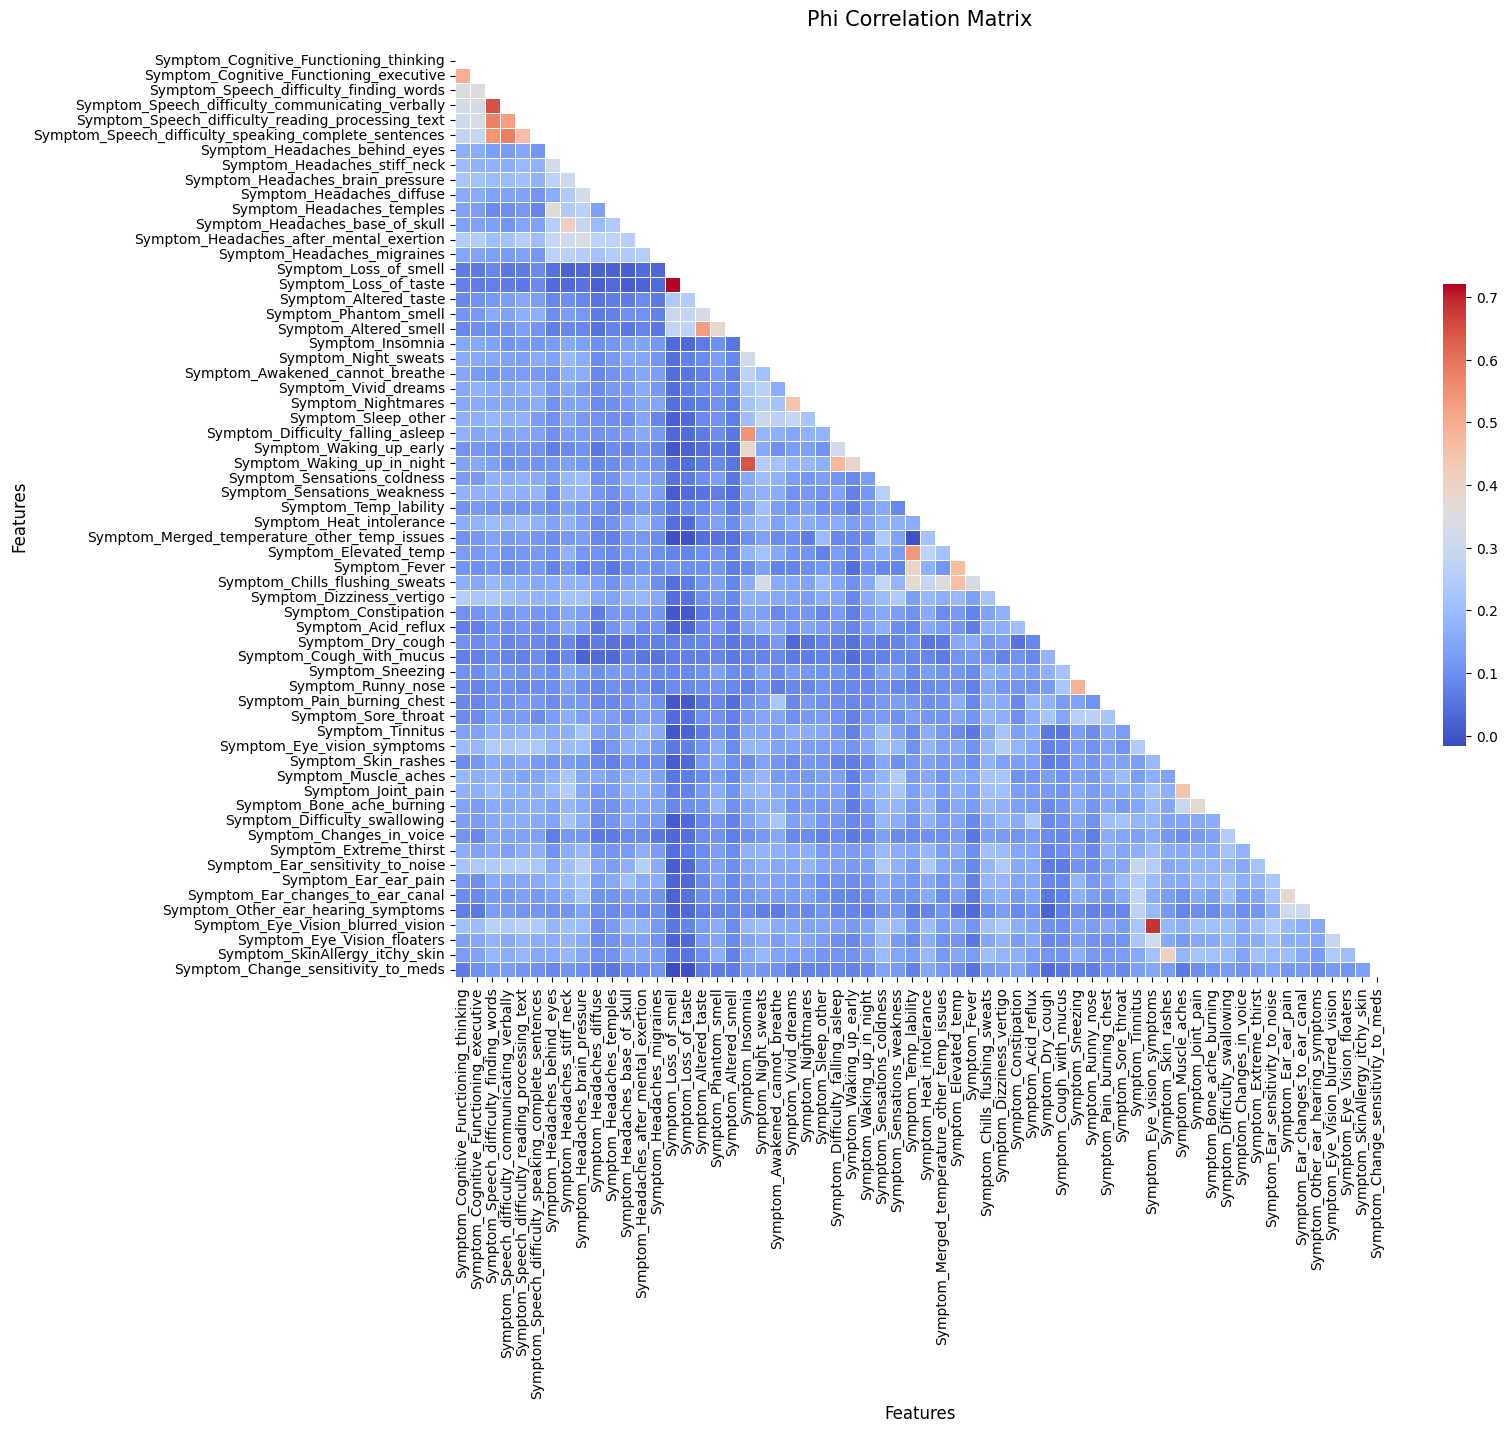

Correlated Feature Pairs (Phi Correlation > 0.5), Ordered by Correlation:
Symptom_Loss_of_smell - Symptom_Loss_of_taste: 0.72
Symptom_Eye_vision_symptoms - Symptom_Eye_Vision_blurred_vision: 0.68
Symptom_Speech_difficulty_finding_words - Symptom_Speech_difficulty_communicating_verbally: 0.65
Symptom_Insomnia - Symptom_Waking_up_in_night: 0.64
Symptom_Speech_difficulty_communicating_verbally - Symptom_Speech_difficulty_speaking_complete_sentences: 0.58
Symptom_Speech_difficulty_finding_words - Symptom_Speech_difficulty_reading_processing_text: 0.58
Symptom_Insomnia - Symptom_Difficulty_falling_asleep: 0.55
Symptom_Speech_difficulty_finding_words - Symptom_Speech_difficulty_speaking_complete_sentences: 0.55
Symptom_Temp_lability - Symptom_Elevated_temp: 0.54
Symptom_Altered_taste - Symptom_Altered_smell: 0.53
Symptom_Speech_difficulty_communicating_verbally - Symptom_Speech_difficulty_reading_processing_text: 0.52


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to compute the phi coefficient for binary variables


# Assuming 'dataset_no_skew' is your binary dataset
# Example: dataset_no_skew = pd.DataFrame(...)

# Compute the phi correlation matrix
phi_corr_matrix = pd.DataFrame(index=dataset_no_skew.columns, columns=dataset_no_skew.columns)
for col1 in dataset_no_skew.columns:
    for col2 in dataset_no_skew.columns:
        phi_corr_matrix.loc[col1, col2] = phi_coefficient(dataset_no_skew[col1], dataset_no_skew[col2])

# Plotting the heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(phi_corr_matrix, dtype=bool))
sns.heatmap(phi_corr_matrix.astype(float), mask=mask, cmap='coolwarm', annot=False, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Phi Correlation Matrix', fontsize=15, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

# Define a threshold for high correlation
correlation_threshold = 0.5

# Identify and print highly correlated pairs
correlated_pairs = []
for i, j in zip(*np.triu_indices_from(phi_corr_matrix, k=1)):
    if abs(float(phi_corr_matrix.iloc[i, j])) > correlation_threshold:
        correlated_pairs.append((phi_corr_matrix.columns[i], phi_corr_matrix.columns[j], phi_corr_matrix.iloc[i, j]))

correlated_pairs.sort(key=lambda pair: -abs(float(pair[2])))

print("Correlated Feature Pairs (Phi Correlation > 0.5), Ordered by Correlation:")
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {float(pair[2]):.2f}")


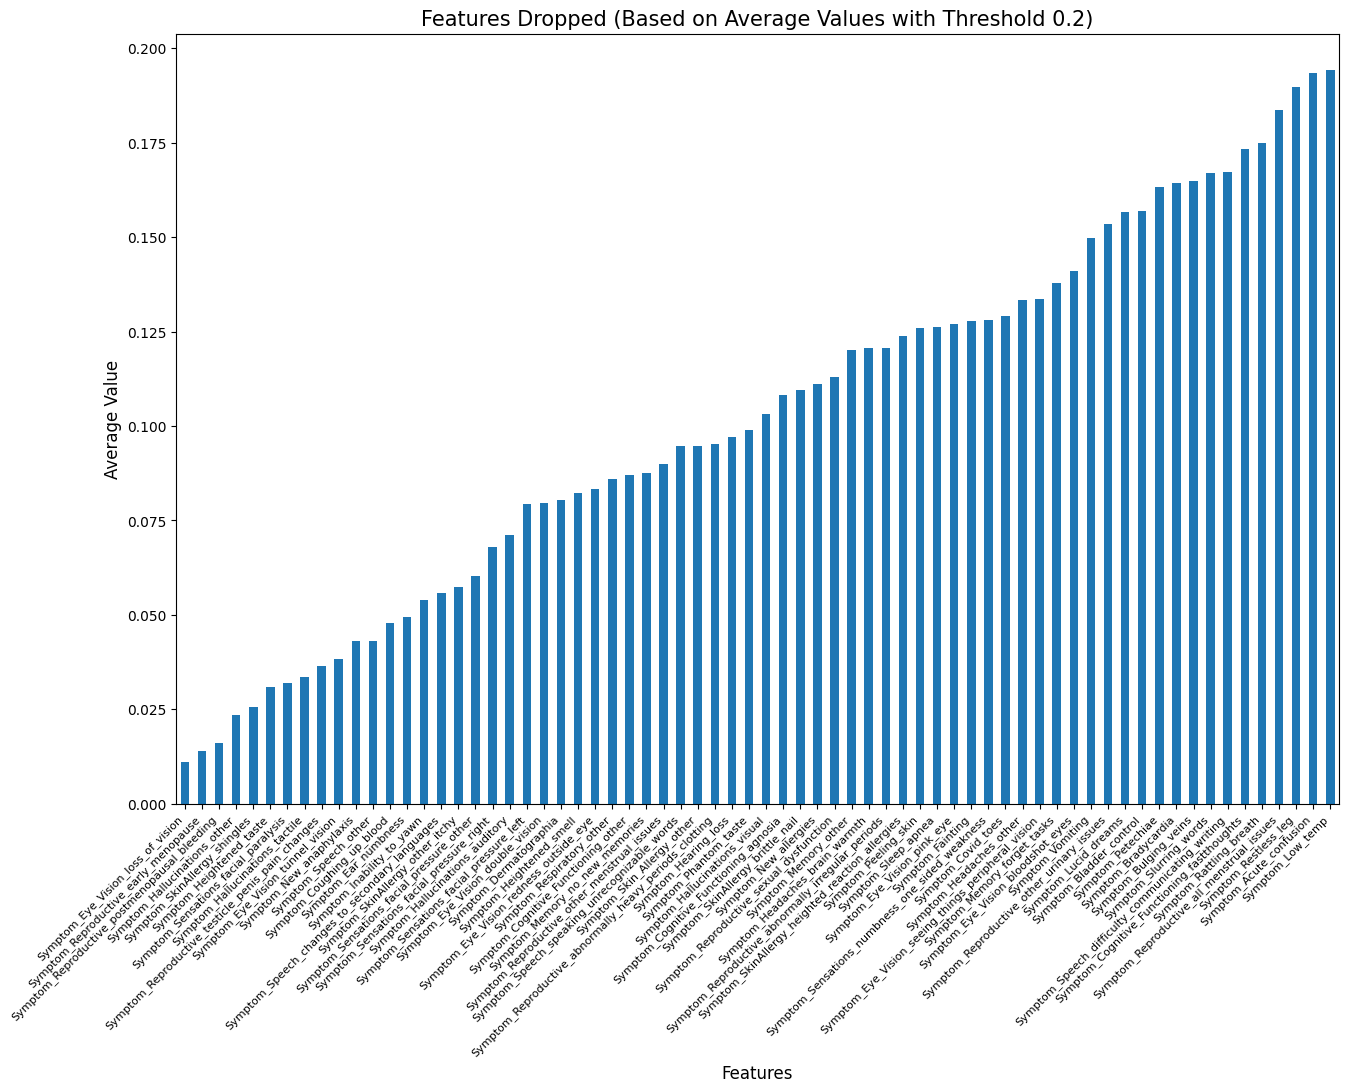

Features Dropped (Based on Average Values with Threshold 0.8): Symptom_Eye_Vision_loss_of_vision: 0.0111, Symptom_Reproductive_early_menopause: 0.0139, Symptom_Reproductive_postmenopausal_bleeding: 0.0161, Symptom_Hallucinations_other: 0.0234, Symptom_SkinAllergy_shingles: 0.0257, Symptom_Heightened_taste: 0.0308, Symptom_Sensations_facial_paralysis: 0.0320, Symptom_Hallucinations_tactile: 0.0337, Symptom_Reproductive_testicle_penis_pain_changes: 0.0365, Symptom_Eye_Vision_tunnel_vision: 0.0383, Symptom_New_anaphylaxis: 0.0429, Symptom_Speech_other: 0.0431, Symptom_Coughing_up_blood: 0.0479, Symptom_Ear_numbness: 0.0494, Symptom_Inability_to_yawn: 0.0541, Symptom_Speech_changes_to_secondary_languages: 0.0557, Symptom_SkinAllergy_other_itchy: 0.0574, Symptom_Sensations_facial_pressure_other: 0.0602, Symptom_Sensations_facial_pressure_right: 0.0680, Symptom_Hallucinations_auditory: 0.0711, Symptom_Sensations_facial_pressure_left: 0.0793, Symptom_Eye_Vision_double_vision: 0.0796, Symptom_

In [26]:
# Load your dataset
dataset = pd.read_csv(f'/Users/leo/Programming/PLR/Leo/data/dataset_{opt_params["dataset"]}.csv').drop('Unnamed: 0', axis=1)

# Calculate the average for each feature
feature_averages = dataset.mean()

# Identify features that would be dropped based on the provided threshold
threshold = opt_params['skew_threshold']  # Assuming this is defined in opt_params
dropped_features = feature_averages[(feature_averages > threshold) | (feature_averages < (1 - threshold))]

# Sort the dropped features in ascending order
sorted_dropped_features = dropped_features.sort_values(ascending=True)

# Create a bar plot for the features that were dropped
plt.figure(figsize=(15, 10))
sorted_dropped_features.plot(kind='bar')
plt.title(f'Features Dropped (Based on Average Values with Threshold {round(1 - threshold,2)})', fontsize=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate labels for better visibility and smaller size
plt.show()

# Print the dropped features and their averages
dropped_features_str = ', '.join([f"{feature}: {avg:.4f}" for feature, avg in sorted_dropped_features.items()])
print(f"Features Dropped (Based on Average Values with Threshold {threshold}): {dropped_features_str}")



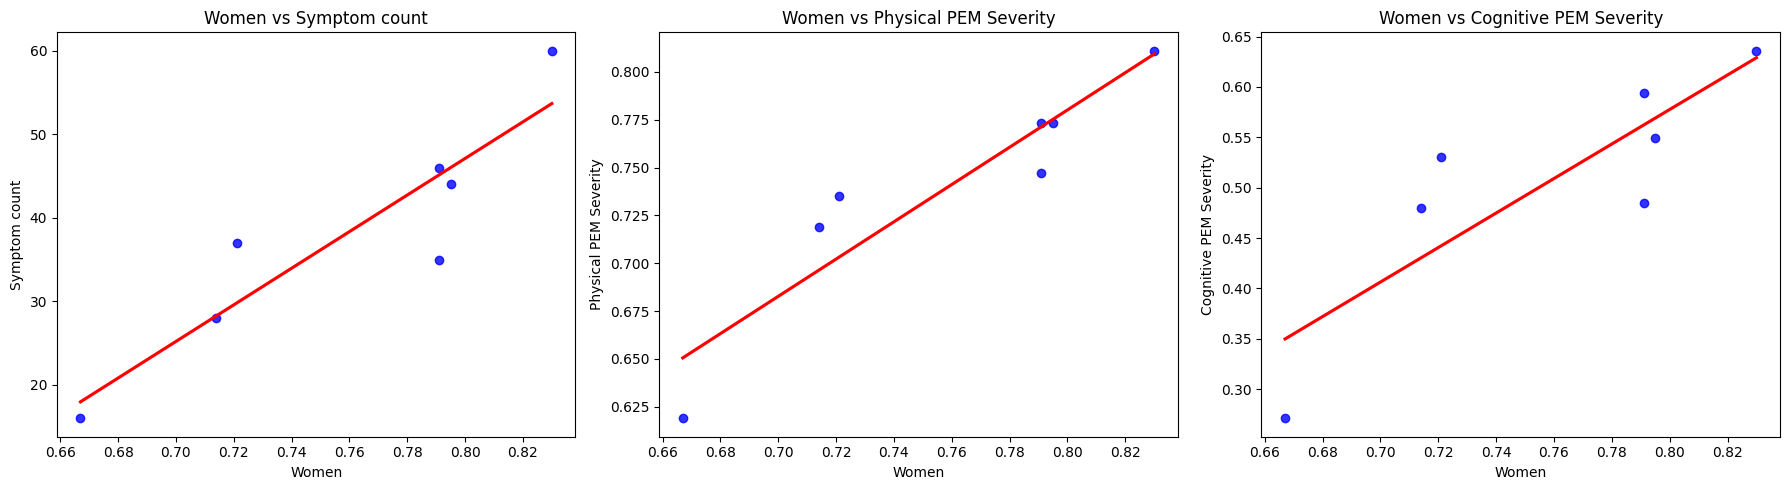

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Sample data in a dictionary format
data = {
    'Cluster Name': ['AX', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5'],
    'Size': [222, 1125, 2126, 321, 498, 850, 889],
    'Symptom count': [16, 44, 60, 35, 46, 28, 37],
    'Women': [0.667, 0.795, 0.830, 0.791, 0.791, 0.714, 0.721],
    'Physical PEM Severity': [0.619, 0.773, 0.811, 0.747, 0.773, 0.719, 0.735],
    'Cognitive PEM Severity': [0.271, 0.549, 0.636, 0.485, 0.594, 0.480, 0.530]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plots with trend lines
sns.regplot(ax=axes[0], x='Women', y='Symptom count', data=df, scatter=True, ci=None, color='blue', line_kws={'color': 'red'})
axes[0].set_title('Women vs Symptom count')

sns.regplot(ax=axes[1], x='Women', y='Physical PEM Severity', data=df, scatter=True, ci=None, color='blue', line_kws={'color': 'red'})
axes[1].set_title('Women vs Physical PEM Severity')

sns.regplot(ax=axes[2], x='Women', y='Cognitive PEM Severity', data=df, scatter=True, ci=None, color='blue', line_kws={'color': 'red'})
axes[2].set_title('Women vs Cognitive PEM Severity')

plt.tight_layout()
plt.show()


In [29]:
import pandas as pd

# Define the data
data = {
    'Comparison': ['Women vs Symptom count', 'Women vs Physical PEM Severity', 'Women vs Cognitive PEM Severity'],
    'Correlation': [0.8829187134416479, 0.9727272727272728, 0.8829187134416479],
    'P-value': [0.008450342381896611, 0.00023248789660928963, 0.008450342381896611]
}

# Create a DataFrame
correlation_table = pd.DataFrame(data)

# Display the table
print(correlation_table)


                        Comparison  Correlation   P-value
0           Women vs Symptom count     0.882919  0.008450
1   Women vs Physical PEM Severity     0.972727  0.000232
2  Women vs Cognitive PEM Severity     0.882919  0.008450


In [30]:
avg_df_grouped.groupby('cluster').mean()

,Memory,Cognitive,Speech,Auditory,Headaches,Olfaction,Gastrointenstinal,Sensory,Motor,Sleep,Vision,Temperature,Cardiac,Respiratory,Allergic,Genitourinary,Skin,Musculoskeletal,Misc
cluster,,,,,,,,,,,,,,,,,,,
-1,0.221622,0.081982,0.048423,0.050050,0.061712,0.175676,0.134635,0.094595,0.083333,0.058559,0.052177,0.082207,0.152252,0.203266,0.097097,0.044144,0.078829,0.070946,0.128734
0,0.326756,0.373600,0.191889,0.193086,0.283200,0.213556,0.369580,0.238420,0.254444,0.203378,0.190593,0.515778,0.451733,0.419333,0.186864,0.089778,0.179778,0.470222,0.277380
1,0.386830,0.471966,0.267874,0.285879,0.376905,0.262935,0.475645,0.329832,0.365357,0.564064,0.284729,0.581903,0.543838,0.468309,0.247622,0.137112,0.240710,0.580550,0.337080
2,0.296573,0.300935,0.122274,0.145033,0.211526,0.179907,0.280374,0.177570,0.196262,0.162305,0.139668,0.366044,0.388785,0.379673,0.125649,0.070093,0.135514,0.352804,0.237908
3,0.327309,0.384739,0.188002,0.204819,0.306426,0.205321,0.364123,0.238956,0.282631,0.470080,0.198293,0.393323,0.470281,0.402108,0.154395,0.090562,0.153112,0.456325,0.280385
4,0.299294,0.312118,0.123529,0.118954,0.193529,0.156176,0.216209,0.153725,0.165000,0.127059,0.115196,0.052206,0.316000,0.337059,0.103660,0.060118,0.089412,0.320882,0.204272
5,0.315636,0.344657,0.153965,0.165104,0.242070,0.183915,0.282340,0.201100,0.241001,0.440270,0.150169,0.064820,0.386727,0.343785,0.135358,0.078403,0.112486,0.377109,0.232254


In [31]:
avg_df_grouped

,Memory,Cognitive,Speech,Auditory,Headaches,Olfaction,Gastrointenstinal,Sensory,Motor,Sleep,Vision,Temperature,Cardiac,Respiratory,Allergic,Genitourinary,Skin,Musculoskeletal,Misc
cluster,,,,,,,,,,,,,,,,,,,
-1,0.221622,0.081982,0.048423,0.050050,0.061712,0.175676,0.134635,0.094595,0.083333,0.058559,0.052177,0.082207,0.152252,0.203266,0.097097,0.044144,0.078829,0.070946,0.128734
0,0.326756,0.373600,0.191889,0.193086,0.283200,0.213556,0.369580,0.238420,0.254444,0.203378,0.190593,0.515778,0.451733,0.419333,0.186864,0.089778,0.179778,0.470222,0.277380
1,0.386830,0.471966,0.267874,0.285879,0.376905,0.262935,0.475645,0.329832,0.365357,0.564064,0.284729,0.581903,0.543838,0.468309,0.247622,0.137112,0.240710,0.580550,0.337080
2,0.296573,0.300935,0.122274,0.145033,0.211526,0.179907,0.280374,0.177570,0.196262,0.162305,0.139668,0.366044,0.388785,0.379673,0.125649,0.070093,0.135514,0.352804,0.237908
3,0.327309,0.384739,0.188002,0.204819,0.306426,0.205321,0.364123,0.238956,0.282631,0.470080,0.198293,0.393323,0.470281,0.402108,0.154395,0.090562,0.153112,0.456325,0.280385
4,0.299294,0.312118,0.123529,0.118954,0.193529,0.156176,0.216209,0.153725,0.165000,0.127059,0.115196,0.052206,0.316000,0.337059,0.103660,0.060118,0.089412,0.320882,0.204272
5,0.315636,0.344657,0.153965,0.165104,0.242070,0.183915,0.282340,0.201100,0.241001,0.440270,0.150169,0.064820,0.386727,0.343785,0.135358,0.078403,0.112486,0.377109,0.232254


In [32]:
# Assuming 'df' is your DataFrame
# Let's say the average temperature-related symptom severity for Cluster A4 is 0.052
cluster_a4_temp_avg = 0.052

# Calculate the mean and standard deviation for temperature-related symptoms across all clusters
temperature_mean = avg_df_grouped['Temperature'].mean()
temperature_std = avg_df_grouped['Temperature'].std()

# Calculate the Z-score for Cluster A4's average temperature-related symptom severity
z_score = (cluster_a4_temp_avg - temperature_mean) / temperature_std

print(f"Mean Temperature Severity Across Clusters: {temperature_mean}")
print(f"Standard Deviation of Temperature Severity Across Clusters: {temperature_std}")
print(f"Z-score for Cluster A4's Temperature Severity: {z_score}")


Mean Temperature Severity Across Clusters: 0.2937543472527903
Standard Deviation of Temperature Severity Across Clusters: 0.2247117896080944
Z-score for Cluster A4's Temperature Severity: -1.075841849127804


In [33]:
df_filtered = avg_df_grouped.loc[avg_df_grouped.index != -1]

# The average temperature-related symptom severity for Cluster A4 remains the same
cluster_a4_temp_avg = 0.052

# Calculate the mean and standard deviation for temperature-related symptoms across non-outlier clusters
temperature_mean_filtered = df_filtered['Temperature'].mean()
temperature_std_filtered = df_filtered['Temperature'].std()

# Calculate the Z-score for Cluster A4's average temperature-related symptom severity, excluding outliers
z_score_filtered = (cluster_a4_temp_avg - temperature_mean_filtered) / temperature_std_filtered

print(f"Mean Temperature Severity Across Non-Outlier Clusters: {temperature_mean_filtered}")
print(f"Standard Deviation of Temperature Severity Across Non-Outlier Clusters: {temperature_std_filtered}")
print(f"Z-score for Cluster A4's Temperature Severity (excluding outliers): {z_score_filtered}")

Mean Temperature Severity Across Non-Outlier Clusters: 0.32901220392705416
Standard Deviation of Temperature Severity Across Non-Outlier Clusters: 0.22394706478460114
Z-score for Cluster A4's Temperature Severity (excluding outliers): -1.2369539390636473


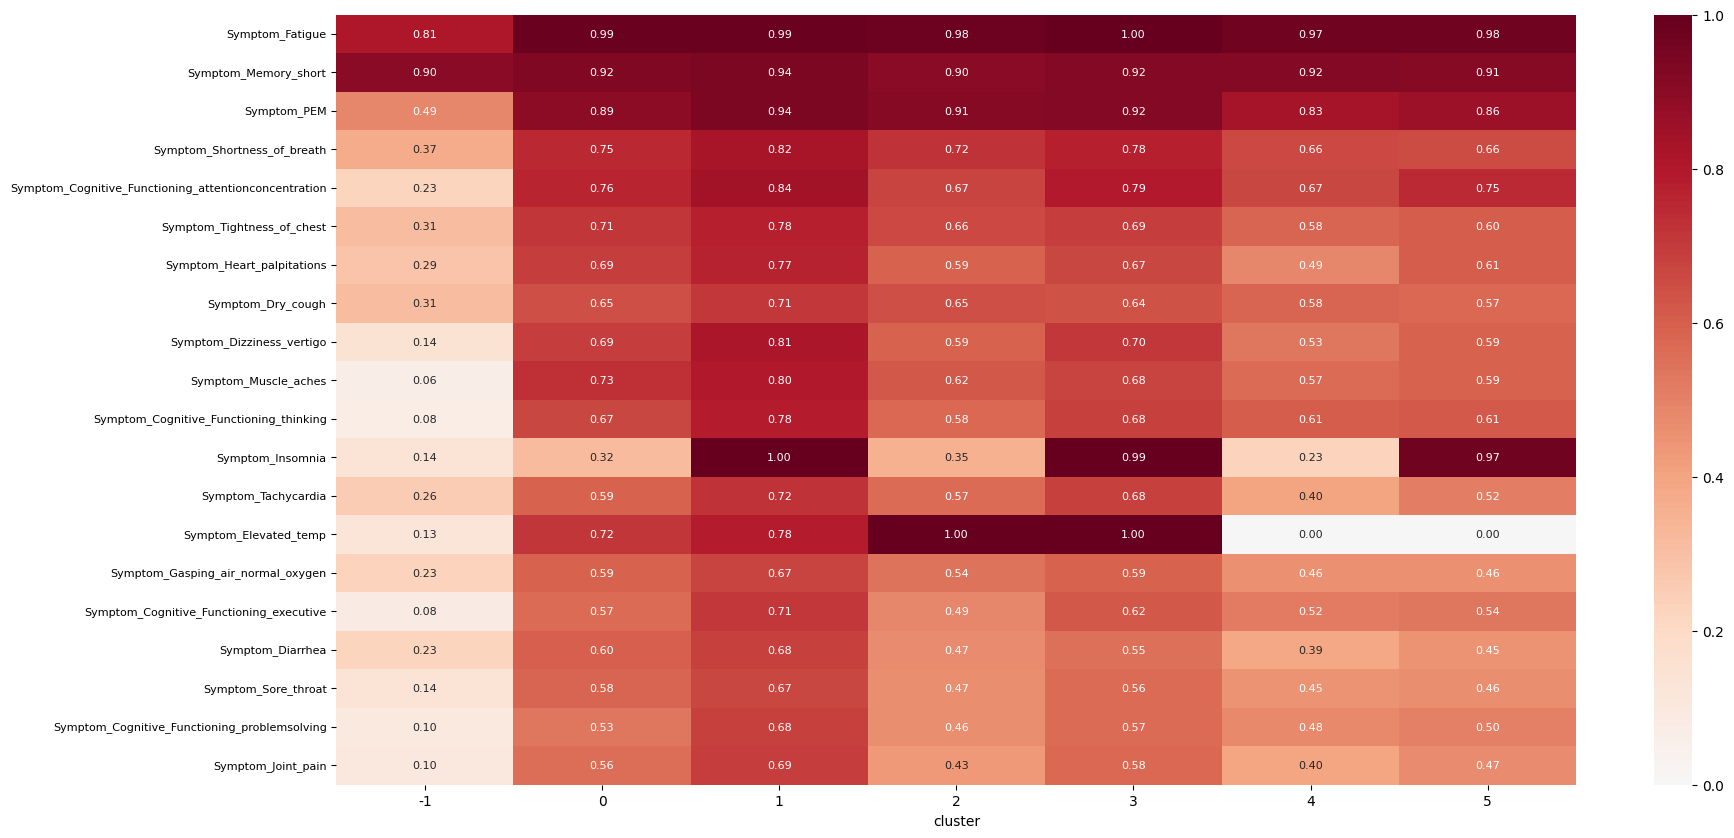

In [39]:
avg_df = plot_symp_avg_per_cluster(
    clusters="/Users/leo/Programming/PLR/clusterings/leo/final_aencoder_hdbscan_6.csv",
    include_misc=False,
    selected_cluster=None,  # Updated to use a numerical cluster label
    top_n_features=20,
    saveloc=None  # Optionally specify a save location for the plot
)